<a href="https://colab.research.google.com/github/JOAQ223/C-learning/blob/main/SPEECH_TO_TEXT_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. JIWER Install

In [ ]:
pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 8.8 MB/s 
     |████████████████████████████████| 2.2 MB 61.0 MB/s 


Import Libraries

In [ ]:
import pandas as pd0
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

**Import LJSpeech Dataset**
* ID: Name of the corresponding wav file
* Transcription: words spoken by the reader (UTF-8)
* Normalized Transcription: transcription with numbers, ordinals, and monetary units expanded into full words (UTF-8)

# https://keithito.com/LJ-Speech-Dataset/

# https://www.kaggle.com/datasets/showmik50/ljspeech-sr16k-dataset

In [ ]:
# Download the dataset
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)

2748572632/2748572632 [==============================] - 130s 0us/step


In [ ]:
#save all the wavs files
wav_path = data_path + "/wavs/"

#save 
metadata_path = data_path + "/metadata.csv"

In [ ]:
#read the metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)

In [ ]:
metadata_df.head(10)

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
5,LJ001-0006,"And it is worth mention in passing that, as an...","And it is worth mention in passing that, as an..."
6,LJ001-0007,"the earliest book printed with movable types, ...","the earliest book printed with movable types, ..."
7,LJ001-0008,has never been surpassed.,has never been surpassed.
8,LJ001-0009,"Printing, then, for our purpose, may be consid...","Printing, then, for our purpose, may be consid..."
9,LJ001-0010,"Now, as all books not primarily intended as pi...","Now, as all books not primarily intended as pi..."


In [ ]:
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ015-0251,The latter was ere long arrested on a charge o...
1,LJ025-0146,And the question whether plants are provided w...
2,LJ039-0190,Simmons testified that familiarity with the bo...


Split the data into training and validation set.

In [ ]:
#split1=int(len(metadata_df) * 0.30)
# 90% for training, the rest of 10% for validation
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validation set: {len(df_val)}")


Size of the training set: 11790
Size of the validation set: 1310


# Prepocessing 

We first prepare the vocabulary to be used

In [ ]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters 
num_to_char = keras.layers.StringLookup( vocabulary=char_to_num.get_vocabulary(), oov_token ="", invert=True)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


We create now a function that describes the transformation that we apply to each element of our dataset.



In [ ]:
char_to_num

In [ ]:
# An integer scalar Tensor. The window length in samples
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384

def encode_single_sample(wav_file, label):
  #############################################
  ## Process the Audio
  #############################################
  # 1. Read wav file
  file = tf.io.read_file(wav_path + wav_file + ".wav")
  # 2. Decode the wav file
  audio, _ = tf.audio.decode_wav(file)
  audio = tf.squeeze(audio, axis=-1)
  # 3. Change type to float
  audio = tf.cast(audio, tf.float32)
  # 4. Get the spectrogram)
  spectrogram = tf.signal.stft(audio, frame_length=frame_length,  frame_step=frame_step, fft_length=fft_length)
  # 5. We only need the magnitude, which can be derived by applying tf.abs
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.math.pow(spectrogram, 0.5)
  # 6. Normalisation
  means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
  stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
  spectrogram = (spectrogram - means) / (stddevs + 1e-10)
  #############################################
  ## Process the Label
  #############################################
  # 7. Convert label to Lower case
  label = tf.strings.lower(label)
  # 8. Split the label
  label = tf.strings.unicode_split(label, input_encoding="UTF-8")
  # 9. Map the characters in label to numbers
  label = char_to_num(label)
  # 10. Return a dict as our model is expecting two inputs
  return spectrogram, label


Creating Dataset Objects

We create a tf.data.Dataset object that yields the transformed elements, in the same order as they appeared in the input.

In [ ]:
batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

#Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
     validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Visualize the data

Let's visualize an example in our dataset, including the audio clip, the spectogram and the corresponding label.

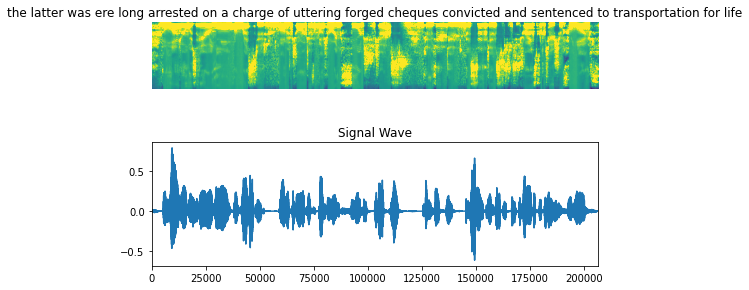

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
  spectrogram = batch[0][0].numpy()
  spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
  label = batch[1][0]
  # Spectrogram
  label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("UTF-8")
  ax = plt.subplot(2, 1, 1)
  ax.imshow(spectrogram, vmax=1)
  ax.set_title(label)
  ax.axis("off")
  # Wav
  file = tf.io.read_file(wav_path + list(df_train["file_name"])[0] + ".wav")
  audio, _ = tf.audio.decode_wav(file)
  audio = audio.numpy()
  ax = plt.subplot(2, 1, 2)
  plt.plot(audio)
  ax.set_title("Signal Wave")
  ax.set_xlim(0, len(audio))
  display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

## Model

We first define the CTC Loss function.

In [ ]:
def CTCLoss(y_true, y_pred):
  # Compute the training-time loss value
  batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
  input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
  label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

  input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

  loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss

We now define our model. We will define a model similar to DeepSpeech2.

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

Training and Evaluating

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

Let's the training process.

In [ ]:
# Define the number of epochs.
epochs = 50
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/50
1/1 [==============================] - 3s 3s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : of referring without rhyme or reason to the constitution as a means of preventing its accomplishment thus creating the general impression
Prediction: s
----------------------------------------------------------------------------------------------------
Target    : mrs reid testified that when she saw oswald he was wearing a tshirt and no jacket
Prediction: s
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 1905s 5s/step - loss: 301.6966 - val_loss: 325.5310
Epoch 2/50
1/1 [==============================] - 1s 660ms/step
--------------------------------------------------------------------------------

Inference

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("UTF-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)chr

1/1 [==============================] - 1s 594ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : vicepresidential car
Prediction: s
----------------------------------------------------------------------------------------------------
Target    : let us go to kilburn for them together said mr fasson growing suspicious
Prediction: ss
----------------------------------------------------------------------------------------------------
Target    : whither he often went to distill the lavender returning to london the same evening
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : with a civil note to the governor saying he had no further use for them all three fugitives were recaptured
Prediction: 
------------------------------

# Conclusion
In practice, you should train for around 50 epochs or more. Each epoch takes approximately 5-6mn using a GeForce RTX 2080 Ti GPU. The model we trained at 50 epochs has a Word Error Rate (WER) ≈ 16% to 17%.